In [2]:
import pandas as pd
import dbnomics as dbn
from statsmodels.tsa.filters.hp_filter import hpfilter
import matplotlib.pyplot as plt
from utils.plotter import plot_with_presidents
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
%matplotlib agg
fig, ax = plt.subplots(figsize=(12,6))

In [3]:
series_codes = {
	'Revenue, % of GDP': 'IMF/FM/A.AR.GGR_G01_GDP_PT',
	'Expenditure, % of GDP': 'IMF/FM/A.AR.G_X_G01_GDP_PT',
	'Gross debt, % of GDP': 'IMF/FM/A.AR.G_XWDG_G01_GDP_PT',
	'GDP, current LCU': 'WB/GEM/A-NYGDPMKTPSACN-ARG',
	'CPI': 'OECD/EO/ARG.CPI.A'
}

In [4]:
raw_expenditure   = dbn.fetch_series(series_codes['Expenditure, % of GDP'])
raw_revenue       = dbn.fetch_series(series_codes['Revenue, % of GDP'])
raw_gross_debt    = dbn.fetch_series(series_codes['Gross debt, % of GDP'])
raw_external_debt = pd.read_excel('../data/argentina_external_debt.xlsx')
raw_employment    = pd.read_csv('../data/argentina_employment.csv')
raw_gdp_nominal   = dbn.fetch_series(series_codes['GDP, current LCU'])
raw_cpi           = dbn.fetch_series(series_codes['CPI'])

In [5]:
coef_elasticity_expenditure = 1.03 # cepal
coef_elasticity_revenue     = 1.23 # cepal

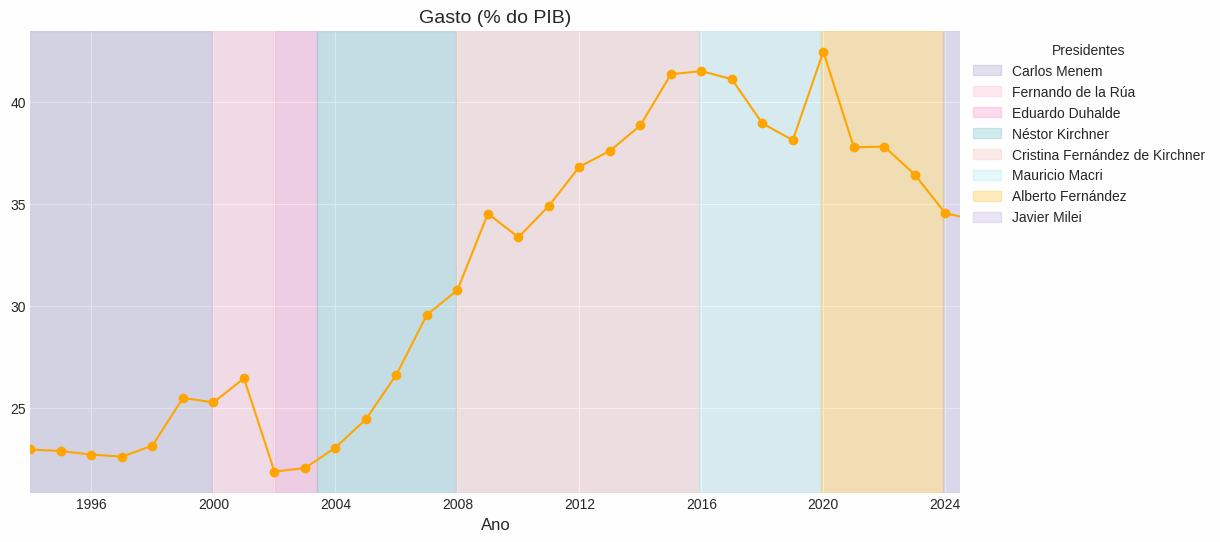

In [6]:
ax.clear()
expenditure = raw_expenditure[['period', 'value']].copy()
expenditure.period = pd.to_datetime(expenditure.period)
expenditure = expenditure.rename(columns={'period': 'year', 'value': 'expenditure'})
expenditure = expenditure.set_index('year')

plot_with_presidents(
	expenditure.index,
	expenditure.expenditure,
	ax=ax,
	title='Gasto (% do PIB)',
	xlabel='Ano'
)

fig

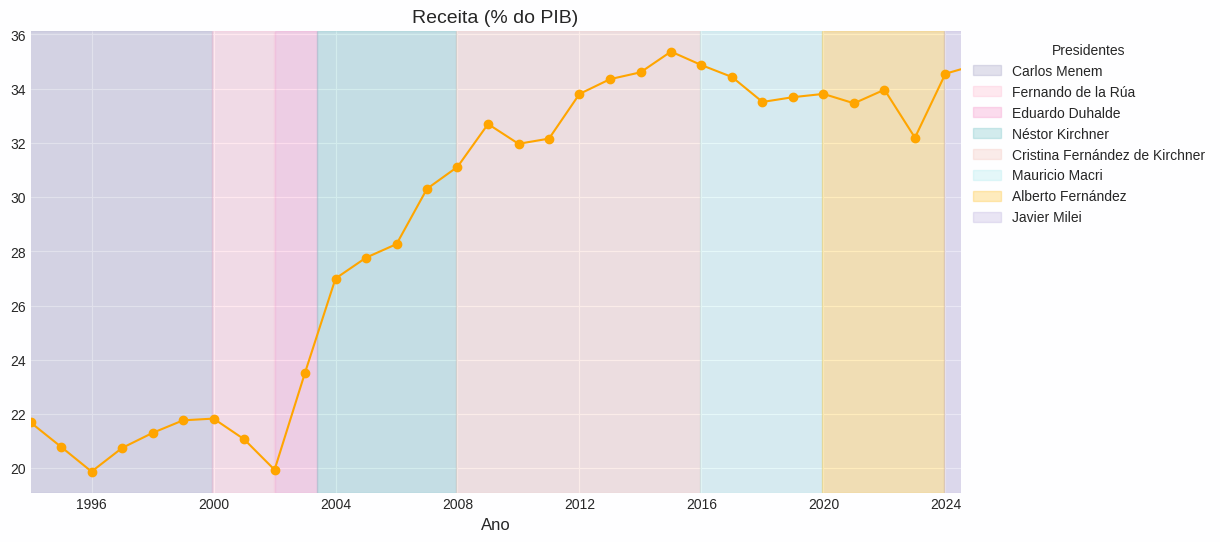

In [7]:
ax.clear()
revenue = raw_revenue[['period', 'value']].copy()
revenue.period = pd.to_datetime(revenue.period)
revenue = revenue.rename(columns={'period': 'year', 'value': 'revenue'})
revenue = revenue.set_index('year')

plot_with_presidents(
	revenue.index,
	revenue.revenue,
	ax=ax,
	title='Receita (% do PIB)',
	xlabel='Ano'
)

fig

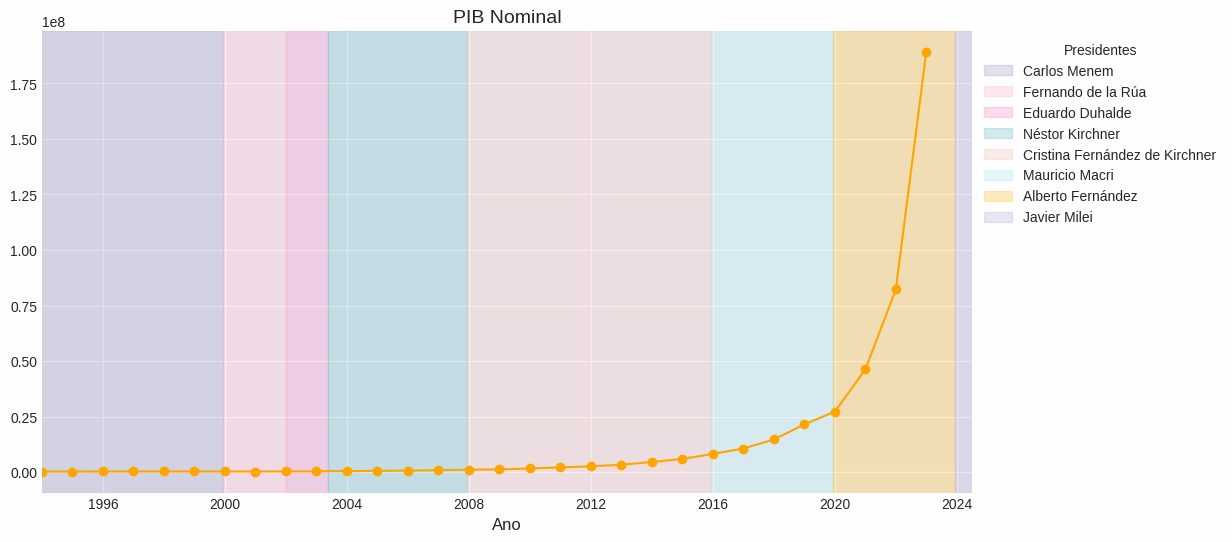

In [8]:
ax.clear()
gdp_nominal = raw_gdp_nominal[['period', 'value']].copy()
gdp_nominal.period = pd.to_datetime(gdp_nominal.period)
gdp_nominal = gdp_nominal.rename(columns={'period': 'year', 'value': 'gdp_nominal'})
gdp_nominal = gdp_nominal.set_index('year')

plot_with_presidents(
	gdp_nominal.index,
	gdp_nominal.gdp_nominal,
	ax=ax,
	title='PIB Nominal',
	xlabel='Ano'
)

fig

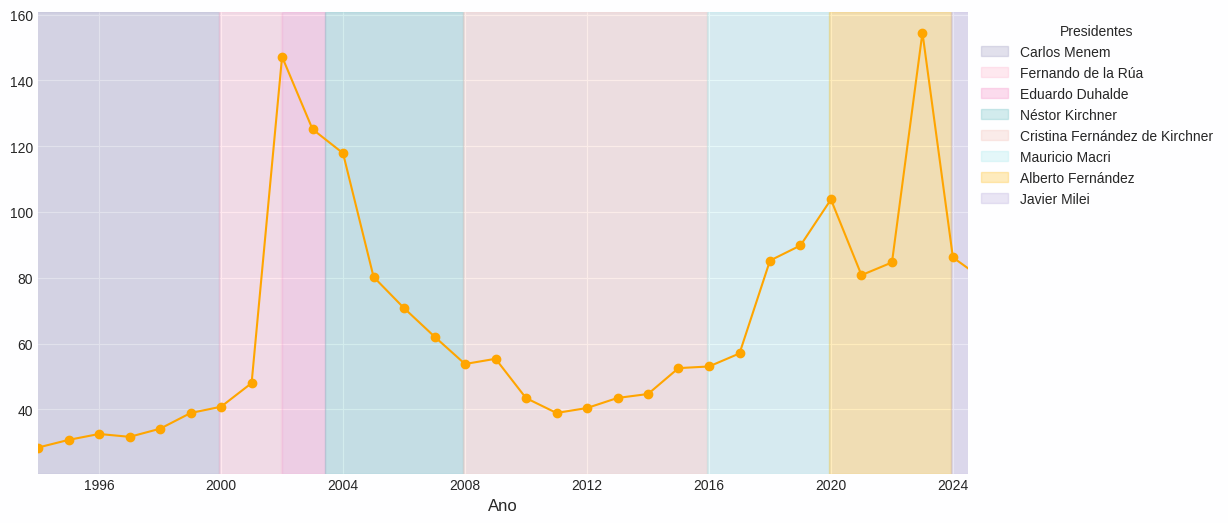

In [9]:
ax.clear()
gross_debt = raw_gross_debt[['period', 'value']].copy()
gross_debt.period = pd.to_datetime(gross_debt.period)
gross_debt = gross_debt.rename(columns={'period': 'year', 'value': 'gross_debt'})
gross_debt = gross_debt.set_index('year')

plot_with_presidents(
	gross_debt.index,
	gross_debt.gross_debt,
	ax=ax,
	# title='Divida Bruta (% do PIB)',
	xlabel='Ano'
)

fig

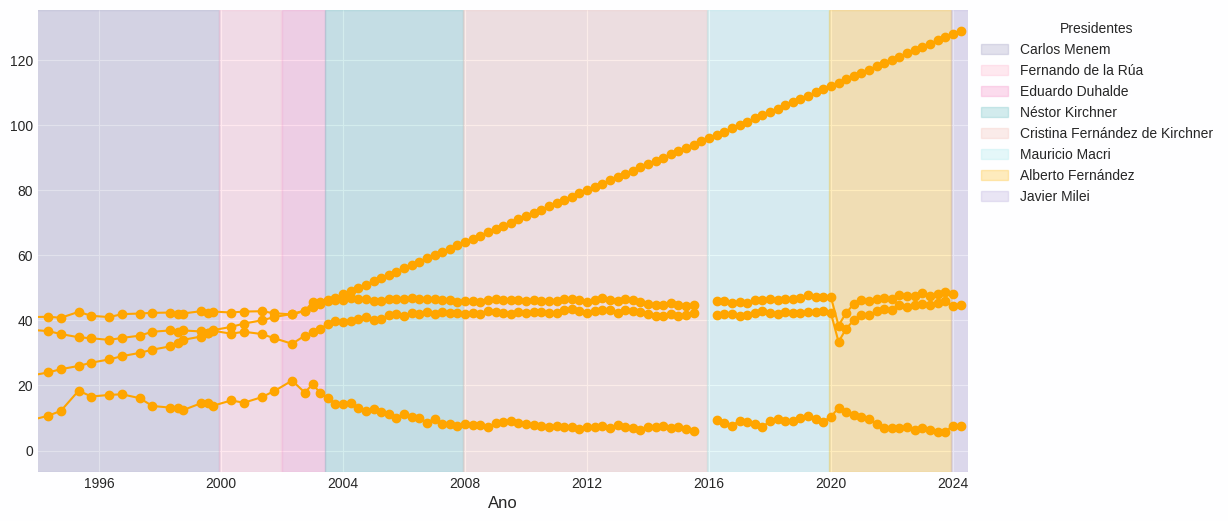

In [10]:
ax.clear()
employment = raw_employment.copy()
employment.date = pd.to_datetime(employment.date)
# employment = employment.rename(columns={'period': 'year', 'value': 'gross_debt'})
employment = employment.set_index('date')

plot_with_presidents(
	employment.index,
	employment,
	ax=ax,
	# title='',
	xlabel='Ano'
)

fig

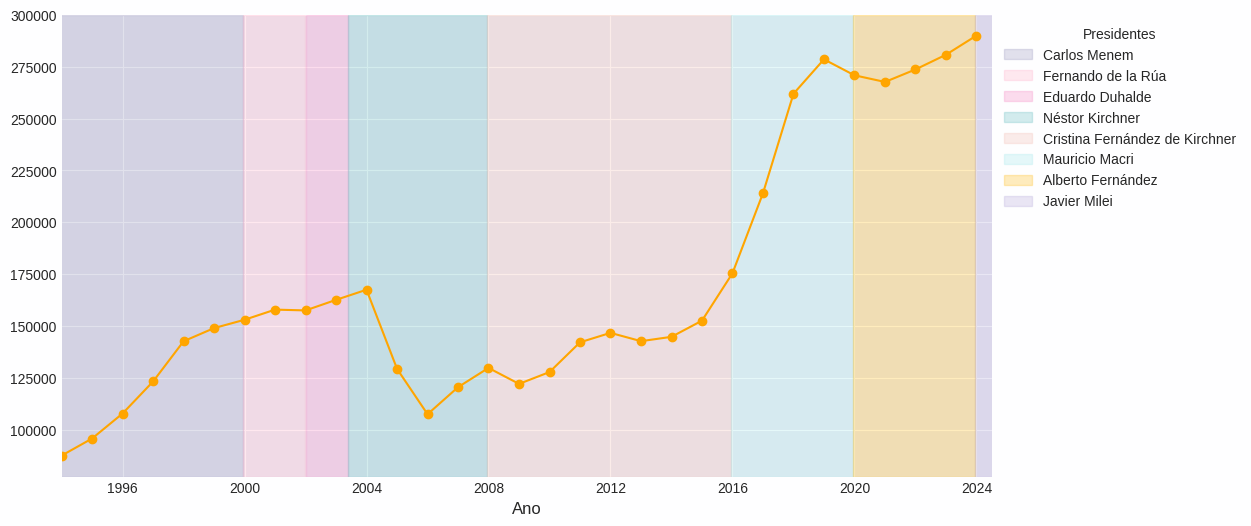

In [11]:
ax.clear()

external_debt = raw_external_debt.copy()
external_debt.date = pd.to_datetime(external_debt.date)
external_debt = external_debt.rename(columns={'date': 'year'})
external_debt = external_debt.set_index('year')
external_debt = external_debt.groupby(external_debt.index.year).mean()

external_debt.index = pd.to_datetime(external_debt.index, format='%Y')

plot_with_presidents(
	external_debt.index,
	external_debt.external_debt,
	ax=ax,
	# title='Divida Externa (em milhões de pesos argentinos)',
	xlabel='Ano'
)

fig

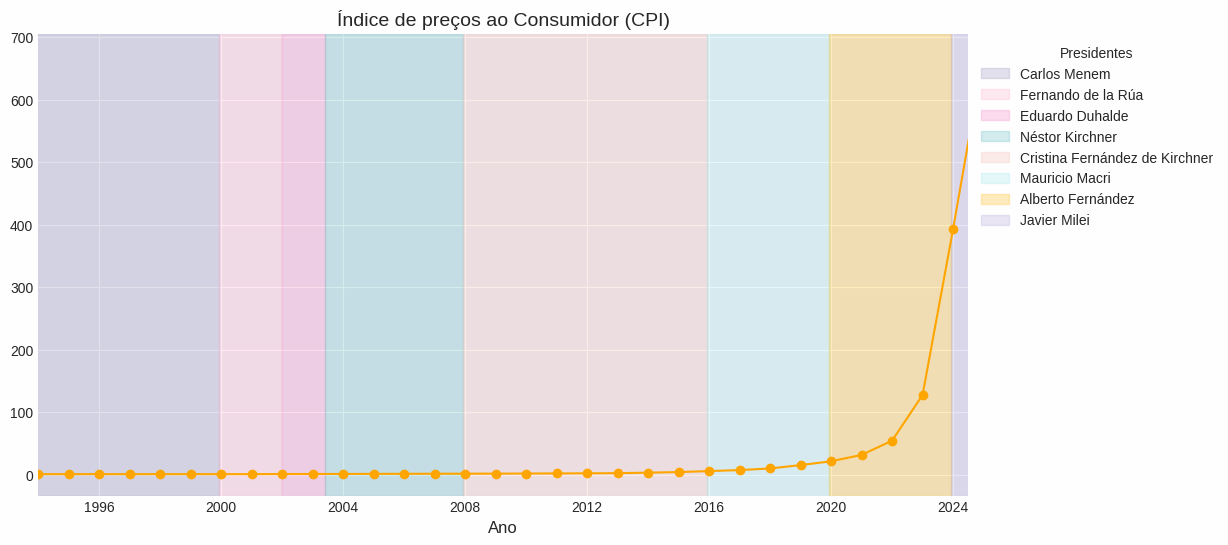

In [12]:
ax.clear()
cpi = raw_cpi[['period', 'value']].copy()
cpi.period = pd.to_datetime(cpi.period)
cpi = cpi.rename(columns={'period': 'year', 'value': 'cpi'})
cpi = cpi.set_index('year')

plot_with_presidents(
	cpi.index,
	cpi.cpi,
	ax=ax,
	title='Índice de preços ao Consumidor (CPI)',
	xlabel='Ano'
)

fig

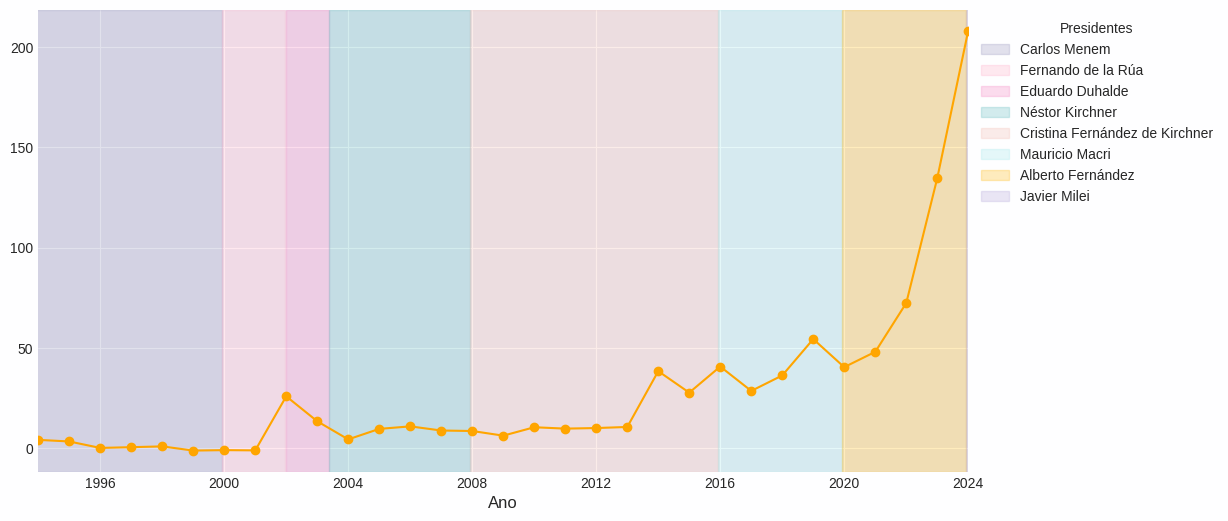

In [19]:
ax.clear()
inflation = cpi.pct_change()
inflation = inflation.rename(columns={'cpi': 'inflation'})
inflation = inflation[(inflation.index>pd.to_datetime('1993-01-01')) & (inflation.index<pd.to_datetime('2025-01-01'))]

plot_with_presidents(
	inflation.index,
	inflation.inflation*100,
	ax=ax,
	# title='Inflação (Variação Anual % do índice)',
	xlim = [pd.to_datetime('1994-01-01'), pd.to_datetime('2024-01-01')],
	xlabel='Ano',
)

fig

In [14]:
argentina = pd.concat([revenue, expenditure, gdp_nominal, gross_debt, external_debt, cpi, inflation], axis=1).dropna()

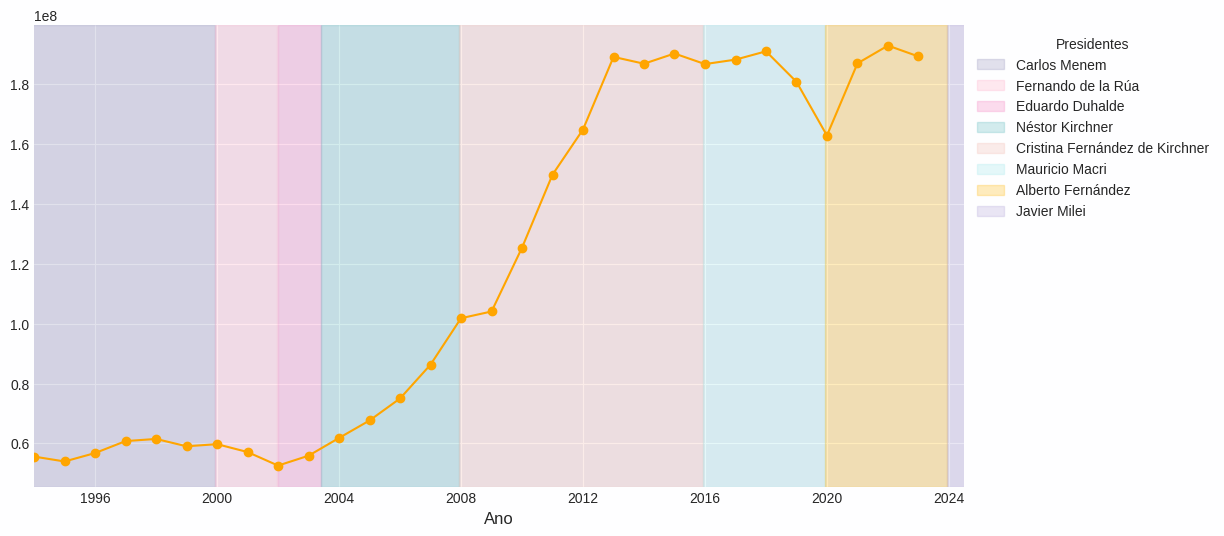

In [15]:
ax.clear()
argentina['gdp_real'] = argentina.gdp_nominal / (argentina.cpi / argentina.loc[pd.to_datetime('2023-01-01'), 'cpi'])

plot_with_presidents(
	argentina.index,
	argentina.gdp_real,
	ax=ax,
	# title='PIB Real (ARS de 2023)',
	xlabel='Ano',
)

fig

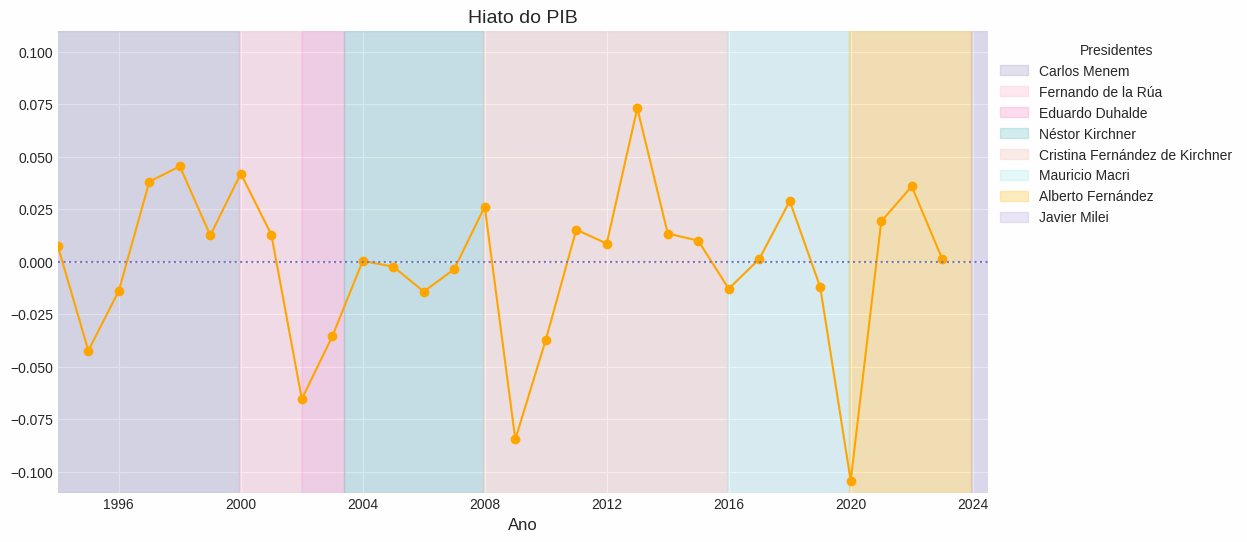

In [16]:
ax.clear()
cycle, trend = hpfilter(argentina.gdp_real, lamb=6.25)
argentina['gdp_potential'] = trend
argentina['gdp_gap'] = (argentina.gdp_real - argentina.gdp_potential) / argentina.gdp_potential

plot_with_presidents(
	argentina.index,
	argentina.gdp_gap,
	ax=ax,
	title='Hiato do PIB',
	xlabel='Ano',
	ylim=[-0.11, 0.11]
)

ax.axhline(0, linestyle=':')

fig#

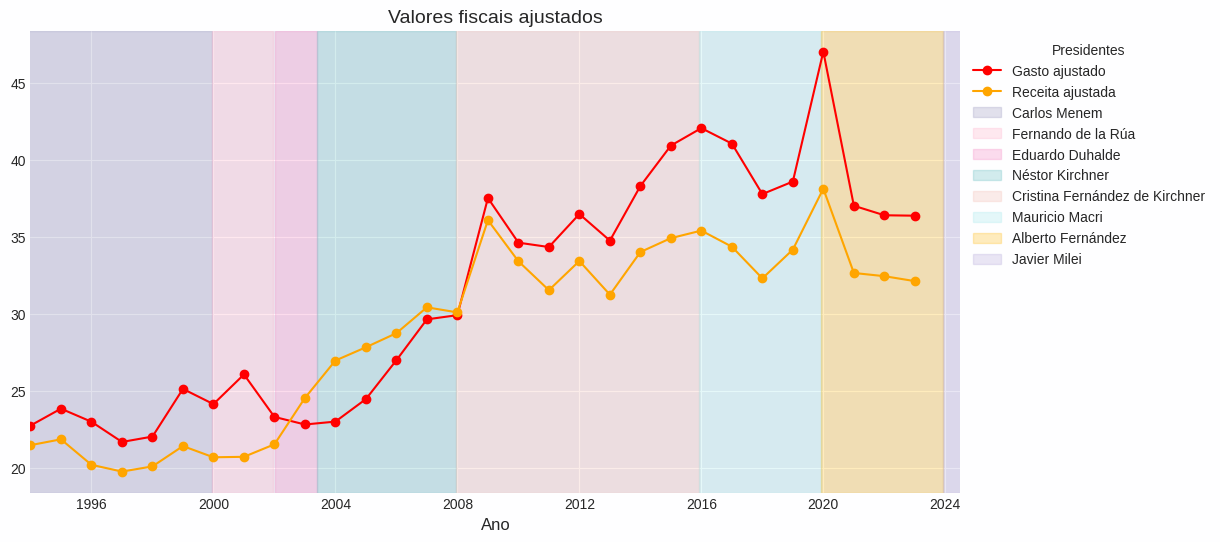

In [17]:
ax.clear()
argentina['revenue_adj']     = argentina.revenue     - coef_elasticity_revenue     * argentina.revenue     * argentina.gdp_gap
argentina['expenditure_adj'] = argentina.expenditure - coef_elasticity_expenditure * argentina.expenditure * argentina.gdp_gap

ax.plot(
	argentina.expenditure_adj,
	marker='o',
	color='red',
	label='Gasto ajustado'
)

plot_with_presidents(
	argentina.index,
	argentina.revenue_adj,
	ax=ax,
	title='Valores fiscais ajustados',
	label='Receita ajustada',
	xlabel='Ano',
)


fig

In [18]:
argentina.to_parquet('../data/argentina_df.parquet')